# Notebook template para a competição Connect X do Virtus-UP.

Nessa competição vamos criar agentes inteligentes para o jogo connect X. Vamos utilizar o mesmo ambiente utilizado na competição https://www.kaggle.com/c/connectx/, essa competição ainda está em andamento.

Para a nossa competição não vamos permitir apenas técnicas da IA clássica.

Leia com atenção os textos. Qualquer dúvida crie uma discursão na página da competição ou mande mensagem para os monitores.

# Setup do Notebook

## IMPORTATE: Habilite a internet no painel lateral. Settings/Internet/On

In [1]:
#Precisamos fazer o download do ambiente de Connect X:
# Vamos precisar de um kaggle-enviroments customizado para a avaliação.
!pip install git+https://github.com/matheusgmaia/kaggle-environments
    

  Cloning https://github.com/matheusgmaia/kaggle-environments to /tmp/pip-req-build-j_pj71v7
  Running command git clone -q https://github.com/matheusgmaia/kaggle-environments /tmp/pip-req-build-j_pj71v7
  Created wheel for kaggle-environments: filename=kaggle_environments-0.2.1-py3-none-any.whl size=283929 sha256=ae25010b55166a90caf4ec4450ecbac949c4ec6dce4c137f6c6886c259128c44
  Stored in directory: /tmp/pip-ephem-wheel-cache-41uqq70k/wheels/19/9f/bf/920b5fc7fdc42bff44e928f46925920688f843af7a28efebe6
Successfully built kaggle-environments
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 0.1.6
    Uninstalling kaggle-environments-0.1.6:
      Successfully uninstalled kaggle-environments-0.1.6


In [2]:
#Criar ambiente
from kaggle_environments import evaluate, make, utils
peca_my_algorithm = 1
peca_algorithm_adv = 2

env = make("connectx", debug=True)
env.render()

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+



# Exemplo de Agente

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.

////


Para a submissão funcionar o agente deve funcionar de maneira encapsulada (sem dependências externas).

(Competição Oficial) Quando o seu seu agente for avaliado em relação a outros agentes não teremos acesso á sua imagem docker do Kaggle. Só as seguintes bibliotecas podem ser importadas: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), e outras podem ser adicionadas no futuro.

(Competição Virtus Up) Pode utilizar bibliotecas diferentes.

# 1. Definição de Jogadores 

### Dependências

In [3]:
import numpy as np
import random 
import math

### Macros

In [4]:
AI = 1
OPPONENT = 2
NONE = 0
WINDOW_SIZE = 4
ROW_LIMIT = 6
COL_LIMIT = 7

# 1. Defininição de Funções

## 1.1. getValidColumns()

A função getValidColumns() serve para informar quais colunas ainda estão disponíveis. A lógica se baseia em:

[[0 0 1 0 0 1 2] <br>
[1 2 1 2 1 2 1] <br>
[1 2 1 2 1 2 1] <br>
[2 1 2 1 2 1 2] <br>
[1 2 1 2 1 2 1] <br>
[1 2 1 2 1 2 1]] <br>

Para qualquer caso, se o primeiro elemento da coluna (de cima para baixo) da matriz estiver com o valor 0, significa que ainda é possível adicionar uma peça nessa posição.

In [5]:
def getValidColumns(table):
    valid_columns = []
    # percorre as colunas do tabuleiro
    for col in range(table.shape[1]):
        if table[0][col] == 0:
            valid_columns.append(col)
    #retorna uma lista com as colunas ainda disponíveis
    return valid_columns

## 1.2 getRowAssociated()

A função recebe a matriz referente ao tabuleiro e a coluna para a qual deseja-se descobrir a linha associada. Retorna esta linha

In [6]:
def getRowAssociated(table,col):
    actual_row = 0
    #Percorre as linhas do tabuleiro com a coluna fixa
    for row in np.arange(0,6,1):
        if table[row][col] == 0:
            actual_row = row
    return actual_row

## 1.3 simulatePieceDrop()

A função recebe o tabuleiro, linha e coluna da jogada e qual o jogador teria a jogada simulada. Retorna o tabuleiro com a jogada deste jogador. 

In [7]:
def simulatePieceDrop(table,row,col,player):
    table[row][col] = player
    return table

## 1.4 getPositiveDiagonal()

Esta função recebe como argumentos o tabuleiro, e as referidas linha e coluna do tabuleiro.  Retorna uma janela de quatro elementos na forma de lista representando a diagonal positiva que se inicia na posição table[row][col]

In [8]:
def getPositiveDiagonal(table,row,col):
    array = []
    for index in range(WINDOW_SIZE):
        # o indexador serve para percorrer os elementos da matriz de forma diagonal, aumentando uma unidade em relação ao deslocamento anterior em ambas as dimensões
        array.append(table[row+index][col+index])
    return np.array(array)

## 1.5 getNegativeDiagonal() 

Esta função recebe como argumentos o tabuleiro, e as referidas linha e coluna do tabuleiro.  Retorna uma janela de quatro elementos na forma de lista representando a diagonal negativa que se inicia na posição table[row][col]

In [9]:
def getNegativeDiagonal(table,row,col):
    array = []
    for index in range(WINDOW_SIZE):
        # o indexador serve para percorrer os elementos da matriz de forma diagonal, aumentando uma unidade em relação ao deslocamento anterior na dimensão da linha e 
        #diminuindo uma unidade na dimensão das colunas (percurso da diagonal negativa)
        array.append(table[row-index][col+index])
    return np.array(array)

In [10]:
for index in range(WINDOW_SIZE):
    print(index)

0
1
2
3


## 1.6 getScore()

Esta função recebe uma janela de quatro elementos e retorna a pontuação associada a ela. Ela serve como base para avaliar uma jogada hipotética e descobrir se ela é a mais apropriada para o momento. Maiores detalhes encontram-se como comentários no código.

In [11]:
def getScore(elements):
    window = list(elements)
    score = 0
    #-------------- ATAQUE ------------------
    #Caso haja quatro peças referentes ao agente inteligente, a maior bonificação deve ser atribuída a esta situação. Essa seria a situação de vitória
    if window.count(AI) == 4:
        score = 1000
    #Se houver três peças associadas ao agente inteligente em sequencia e uma posição vazia, significa que a bonificação deve ser média
    elif (window.count(AI) == 3) and (window.count(NONE) == 1):
        score = 250
    #No caso de haver duas peças da IA em sequência na janela e uma posição vazia, esta é a menor das bonificações
    elif (window.count(AI) == 2) and (window.count(NONE == 2)):
        score = 100
    # ------------ DEFESA ------------------
    # A lógica de análise da janela aqui é a mesma, mas punindo o agente em situações que favoreçam o oponente
    elif (window.count(OPPONENT) == 4):
        score = -2000
    elif (window.count(OPPONENT) == 3) and (window.count(NONE) == 1):
        score = -1000
    elif (window.count(OPPONENT) == 2) and (window.count(NONE) == 2):
        score = -300
    return score

## 1.7 analyze()

A função analyze(), por sua vez, é responsável pelo laço que percorre todo o tabuleiro. Recebe como parametro o tabuleiro e retorna a pontuação associada a ele. 

In [12]:

def analyze(table):
    score = 0
    for row in range(ROW_LIMIT):
        for col in range(COL_LIMIT):
            #Teste vertical. Só pode ir até a coluna central do tabuleiro, pois somente até ela é possível selecionar 4 elementos em sequência
            if col < COL_LIMIT - 3:
                #seleciona uma janela de quatro elementos que corresponde a um vetor linha
                horizontal =  table[row][col:col+4]
                score = score + getScore(horizontal)
            #Teste horizontal. Só pode ir até a linha 2, já que somente até ela pode-se selecionar quatro elementos seguidos. 
            if row < ROW_LIMIT-3: 
                #pega um slice de quatro elementos na vertical
                vertical = table[row:row+4,[col]]
                #faz um transpose para transformar o array coluna
                vertical = vertical.transpose()[0]
                score = score + getScore(vertical)
            #Teste da diagonal positiva. É uma combinação das condições anteriores que permite selecionar quatro elementos em sequência sem exceder os limites da matriz
            if (col < COL_LIMIT - 3) & (row < ROW_LIMIT -3):
                positive_diagonal =  getPositiveDiagonal(table,row,col)
                score = score + getScore(positive_diagonal)
            #Esta é o inverso da anterior para ser possível analisar os elementos na diagonal positiva sem exceder os limites do tabuleiro.
            if (row >=3) & (col<=3):
                negative_diagonal = getNegativeDiagonal(table,row,col)
                score = score + getScore(negative_diagonal)
                
    return score

## 1.8 getBestColumnToDrop()

Esta função recebe o tabuleiro e as colunas disponíveis para jogada. Retorna a melhor coluna, ou seja, a que resulta em uma maior pontuação no sistema de recompensas. Ela é uma espécie de simulação para verificar o sistema de pontuação, um minimax com profundiade 1.

In [13]:
def getBestColumnToDrop(table,valid_columns):
    max_score = -50000
    #escolhe qualquer uma da lista só para servir de base para a troca
    best_column = random.choice(valid_columns)
    
    for valid_column in valid_columns:
        #chama a função que diz qual é a linha associada à coluna válida atual do laço
        row = getRowAssociated(table,valid_column)
        table_simulated = table.copy()
        #chama a função para simular o tabuleiro com a atual coluna válida e a linha. 
        table_simulated = simulatePieceDrop(table_simulated,row,valid_column,AI)
        #chama a função para analisar o tabuleiro diante dessa jogada
        temp_score = analyze(table_simulated)
        #se a jogada atual resultar em uma pontuação melhor do que a anterior, a pontuação máxima é atualizada e a melhor coluna também.
        if temp_score > max_score:
            max_score = temp_score
            best_column = valid_column
    
    return best_column

## 1.9 isLastMove()

In [14]:
def isLastMove(table,player):
    
    for row in range(ROW_LIMIT):
        for col in range(COL_LIMIT):
            
            #Teste vertical. Só pode ir até a coluna central do tabuleiro, pois somente até ela é possível selecionar 4 elementos em sequência
            if col < COL_LIMIT - 3:
                #seleciona uma janela de quatro elementos que corresponde a um vetor linha
                horizontal =  table[row][col:col+4]
                window = list(horizontal)
                if window.count(player) == 4:
                    return True
                
            #Teste horizontal. Só pode ir até a linha 2, já que somente até ela pode-se selecionar quatro elementos seguidos. 
            if row < ROW_LIMIT-3: 
                #pega um slice de quatro elementos na vertical
                vertical = table[row:row+4,[col]]
                vertical = vertical.transpose()[0]
                window = list(vertical)
                if window.count(player) == 4:
                    return True
                
            #Teste da diagonal positiva. É uma combinação das condições anteriores que permite selecionar quatro elementos em sequência sem exceder os limites da matriz
            if (col < COL_LIMIT - 3) & (row < ROW_LIMIT -3):
                positive_diagonal =  getPositiveDiagonal(table,row,col)
                window = list(positive_diagonal)
                if window.count(player) == 4:
                    return True
            #Esta é o inverso da anterior para ser possível analisar os elementos na diagonal positiva sem exceder os limites do tabuleiro.
            if (row >=3) & (col<=3):
                negative_diagonal = getNegativeDiagonal(table,row,col)
                window = list(negative_diagonal)
                if window.count(player) == 4:
                    return True
    return False

# 1.10 isLastNode()

Há três possibilidades para que o atual cenário seja o último:
* O tabuleiro já foi preenchido e não há mais colunas válidas
* Há quatro peças da IA em sequência
* Há quatro peças do oponente em sequencia
Retorna uma operação lógica OR entre as condiçõpes possíveis

In [15]:
def isLastNode(table):
    return len(getValidColumns(table)) == 0 or isLastMove(table,AI) or isLastMove(table,OPPONENT)

## 1.11 Minimax

Do livro Artificial Intelligence, seção 5.2.2, temos o pseudocódigo do minimax. 

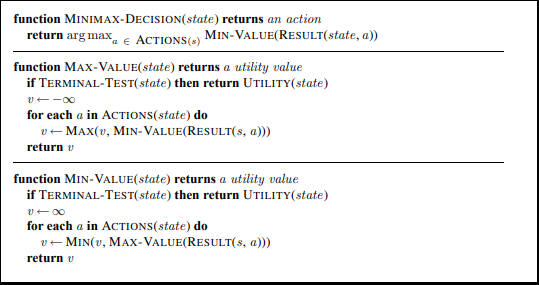

Onde: 
* Nó: representa um estado. No nosso caso, cada possível coluna é um n
* Profundidade: quão profundamente deseja-se ir nas possíveis decisões
* Maximizador: é o que indica qual é o nosso objetivo. Se é maximizar as chances de vitória da IA ou minimizar as chances do oponente vencer

## 1.11.1 Implementando o minimax()

O minimax age de forma recursiva. Utilizou-se a poda alfa-beta para limitar o número de jogadas possíveis somente às que mais compensam ao maximizing player. Alguns comentários abaixo ilustram as codificações feitas.

In [16]:
def minimax(table, depth,alfa,beta, maximizing_player):
    #testa se é a ultima jogada de qualquer um dos jogadores ou se o tabuleiro já foi preenchido 
    if (isLastNode(table) == 1) or (depth==0):
        #testa se eh o ultimo cenario possivel
        if isLastNode(table) == 1:
            #Caso haja 1 peça faltante da IA, isso indica que o jogo já foi ganho. A heurística retorna um valor muito alto e nenhuma coluna
            if isLastMove(table,AI):
                return (None,+math.inf)
            elif isLastMove(table,OPPONENT):
                return (None,-math.inf)
            else:
                return (None,0)
        #trata-se do caso em que depth==0
        else:
            #Caso ainda nao seja o ultimo cenário, a pontuação do tabuleiro deve ser avaliada pela função analyze(), que vai procurar por linhas horizontais, verticais e diagonais positivas e negativas
            return (None,analyze(table))
    # Caso o parametro seja passado como True (maximizar as chances de um determinado player), entra aqui
    if maximizing_player == 1:
        #valor minimo para ser substituido logo nas primeiras iterações
        value = -math.inf
        valid_columns = getValidColumns(table)
        #print("colunas validas: ", valid_columns)
        best_column = random.choice(valid_columns)
        #diante das possíveis colunas a se jogar, percorre cada uma delas avaliando qual produz maior score
        for valid_column in valid_columns:
            #pega a linha associada a essa coluna vazia
            row = getRowAssociated(table,valid_column)
            table_simulated = table.copy()
            #simula a queda de uma peça na posição vazia em questão
            table_simulated = simulatePieceDrop(table_simulated,row,valid_column,AI)
            #chama recursivamente o minimax. O argumento é false porque busca-se avaliar qual seria a jogada do oponente
            score = minimax(table_simulated,depth - 1,alfa,beta,False)[1]
            #caso o score da coluna associada retorne um valor superior ao anterior, este é atualizado e a melhor coluna também
            if score > value:
                value = score
                best_column = valid_column
            alfa  = max(alfa,value)
            if alfa>=beta:
                break
        return (best_column, value)
                
    else:
        value = math.inf
        valid_columns = getValidColumns(table)
        best_column = random.choice(valid_columns)
        for valid_column in valid_columns:
            row = getRowAssociated(table,valid_column)
            table_simulated = table.copy()
            table_simulated = simulatePieceDrop(table_simulated,row,valid_column,OPPONENT)
            #chama recursivamente a próxima jogada do AI até que depth=0
            score = minimax(table_simulated,depth-1,alfa,beta,True)[1]
            #Como o objetivo é minimizar as chances do oponente, quanto menor o valor do score associado ao tabuleiro, melhor. A coluna é atualizada e o valor de value tambén
            if score < value:
                value = score 
                best_column = valid_column
            beta = min(beta,value)
            if beta >= alfa:
                break
            #print("BEST COL: ", best_column)
        return (best_column,value)
            
        

# 2. Definição do Agente

Nessa função, o estado atual do tabuleiro é convertido para um array bidimensional. Este é passado para a função minimax e esta, recursivamente, analisa uma árvore de possibilidades que retorne, para o estado atual, a melhor coluna a ser jogada. 

In [17]:
#minimax(table, depth,alfa,beta,maximizing_player):
def my_agent(obs, cfg): #recebe o estado atual do jogo e a configuração do jogo
    tabuleiro = obs.board
    tabuleiro = np.asarray(tabuleiro).reshape(6,7)
    alfa = -math.inf
    beta = +math.inf
    coluna, score = minimax(tabuleiro,2,alfa,beta,True)
    return coluna

# Testar o seu Agente

Este trecho simula o comportamento do agente contra um agente randômico.

In [18]:
env.reset()
env.run(["negamax",my_agent]) #Agente definido em my_agent versus angente randômico.
env.render(mode="ipython", width=500, height=450)

# Debug/Train o seu Agent.

Aqui é possível ver como o seu agente funciona a cada etapa.

In [19]:
# Play as first position against random agent.
trainer = env.train([None, "negamax"])

observation = trainer.reset()

while not env.done:
    my_action = my_agent(observation, env.configuration)
    print("Ação do seu agente: Coluna", my_action+1)
    observation, reward, done, info = trainer.step(my_action)
    env.render(mode="ipython", width=100, height=90, header=False, controls=False)
    #print(env.configuration.rows)
env.render()

Ação do seu agente: Coluna 1


Ação do seu agente: Coluna 1


Ação do seu agente: Coluna 7


Ação do seu agente: Coluna 2


Ação do seu agente: Coluna 2


Ação do seu agente: Coluna 6


Ação do seu agente: Coluna 5


Ação do seu agente: Coluna 6


Ação do seu agente: Coluna 6


Ação do seu agente: Coluna 3


Ação do seu agente: Coluna 2


Ação do seu agente: Coluna 3


Ação do seu agente: Coluna 3


Ação do seu agente: Coluna 5


Ação do seu agente: Coluna 6


Ação do seu agente: Coluna 1


Ação do seu agente: Coluna 2


Ação do seu agente: Coluna 7


Ação do seu agente: Coluna 4


Ação do seu agente: Coluna 4


+---+---+---+---+---+---+---+
| 2 | 1 | 2 | 0 | 2 | 2 | 1 |
+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 0 | 1 | 1 | 2 |
+---+---+---+---+---+---+---+
| 1 | 2 | 1 | 0 | 2 | 2 | 2 |
+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 2 | 2 | 1 | 2 |
+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 1 | 2 | 1 | 2 |
+---+---+---+---+---+---+---+



# Jogue você mesmo
Click on any column to place a checker there ("manually select action").

Você pode jogar contra o seu agente ou contra qualquer um dos 4 agentes já definidos (random, negamax, rules, greedy).

In [20]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, my_agent], width=500, height=450) #Altere "rules" por my_agent para jogar contra o seu agente


# Sua vez

* Redefina o seu agente com as técnicas de IA clássicas aprendidas durante o curso. 
* É fundamental entender bem como funciona o jogo e como interagir com ele.
* Utilize as funções de teste e avaliação para te ajudar. 
* Consulte Tutoriais e discurssões (Não copie código).

# Avalie o seu Agente

A submissão na competição do kaggle será o resultado do seu agente contra 4 agentes previamente definidos.
Pode utilizar 

In [21]:
def mean_win_draw(rewards):
    return sum( 1 for r in rewards if (r[0] == 1 or r[0] == 0.)) / len(rewards)

# Run multiple episodes to estimate its performance.
vs_random = mean_win_draw(evaluate("connectx", [my_agent, "random"], num_episodes=10))
print("My Agent vs Random Agent:", vs_random)

vs_negamax = mean_win_draw(evaluate("connectx", [my_agent, "negamax"], num_episodes=10))
print("My Agent vs Negamax Agent:", vs_negamax)

vs_rules = mean_win_draw(evaluate("connectx", [my_agent, "rules"], num_episodes=10))
print("My Agent vs Rule Agent:", vs_rules)

vs_greedy = mean_win_draw(evaluate("connectx", [my_agent, "greedy"], num_episodes=10))
print("My Agent vs Greedy Agent:", vs_greedy)

My Agent vs Random Agent: 1.0
My Agent vs Negamax Agent: 0.8
My Agent vs Rule Agent: 1.0
My Agent vs Greedy Agent: 1.0


# Submissão para O Connect-X Virtus Up

In [22]:
import csv

seu_nome = "Arthur Dimitri"

rows = [['Id', 'Predicted'],['random',vs_random],[ 'negamax', vs_negamax],[ 'rules', vs_rules],[ 'greedy', vs_greedy]]
f = open(seu_nome+'-ConnectX.csv', 'w')
with f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

1. Em Data/output você pode baixar o .csv com o seu resultado atual. Isso está acessível no painel lateral ou após realizar um commit no kernel. 
2. Submeta o csv na página da competição.

No fim da competição os monitores vão fazer um campeonato com todos os agentes.

# Submissão Connect-X Original

Como gerar um arquivo .py do seu agente.

Vamos pedir o arquivo do notebook (.ipynb) ou o arquivo python (.py) em um formulário.

Caso queira competir na competição  original.




In [23]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

<function my_agent at 0x7f375c4db488> written to submission.py


# Validar Submissão para Connect-X Original
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [24]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")


Error: name 'np' is not defined
Failed...


# Submissão para Connect-X Original

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.